In [1]:
%load_ext autoreload
# %load_ext line_profiler
%autoreload 2

In [2]:
import decoding_analysis_vis as dav
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy
import xarray as xr
import pickle
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import namedtuple
import sys, os
sys.path.append('/home/tplas/repos/reproducible_figures/scripts/')
import rep_fig_vis as rfv 
sns.set_palette('colorblind')

In [5]:
all_sess = {}
threshold_max_dff_filtering = 18
for st in ['sens', 'proj']:
    all_sess[st] = dav.AllSessions(sess_type=st, threshold_max_dff_filtering=threshold_max_dff_filtering)


session name : 2020-09-14_RL101.pkl
Excluded 2007 out of 2169 neurons
session name : 2020-10-02_RL108.pkl
Excluded 2254 out of 2563 neurons
session name : 2020-09-16_RL103.pkl
Excluded 1976 out of 2106 neurons
session name : 2020-09-08_RL099.pkl
Excluded 2019 out of 2095 neurons
session name : 2020-09-04_RL093.pkl
Excluded 2043 out of 2097 neurons
session name : 2020-10-12_RL109.pkl
Excluded 2306 out of 2515 neurons
Individual sessions loaded
session name : 2021-02-24_RL132.pkl
Excluded 1906 out of 2156 neurons
session name : 2021-02-18_RL127.pkl
Excluded 2068 out of 2334 neurons
session name : 2021-02-22_RL128.pkl
Excluded 2020 out of 2308 neurons
session name : 2021-02-25_RL131.pkl
Excluded 1865 out of 2448 neurons
session name : 2021-03-02_RL130.pkl
Excluded 2126 out of 2258 neurons
session name : 2021-02-23_RL129.pkl
Excluded 1811 out of 2364 neurons
Individual sessions loaded


<Axes: >

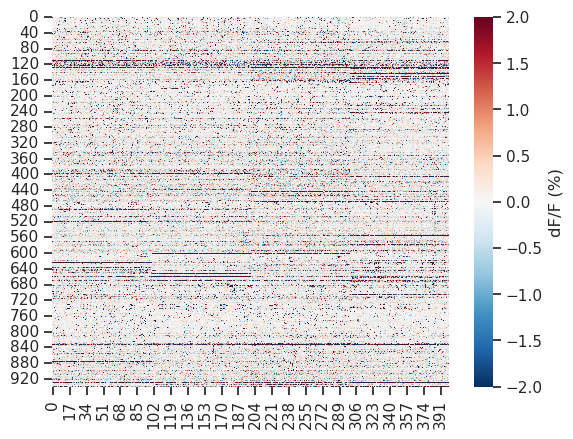

In [18]:
sns.heatmap(all_sess['sens'].create_time_averaged_response(t_min=-1, t_max=6).activity,
            vmin=-2, vmax=2, cmap='RdBu_r', cbar_kws={'label': 'dF/F (%)'})

## Train population decoders:

In [15]:
# fig, ax = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
# i_row, i_col = 0, 0
dict_sess_type_tt = {'sens': ['sensory', 'random', 'whisker'],
                     'proj': ['projecting', 'non_projecting']}
decoder_type = 'logistic_regression'
save_results = False
threshold_max_dff_filtering = 18

for exclude_targets in [True]:
    for t_min in [1.1]:  #[0.1, 0.5, 1.1]: 
        print('\n\n-------\n')
        print(f'Running decoders for t_min = {t_min}, exclude_targets = {exclude_targets}')
        print('\n-------\n\n')
        t_max = t_min + 0.6
        folder_save = '/home/tplas/repos/S1S2_mechanisms/jupyter/thijs/results_decoders/'
        if save_results:
            assert os.path.exists(folder_save), 'Folder does not exist'
            file_name = f'population-decoder_{decoder_type}_exclude_targets_{exclude_targets}_tmin_{t_min}_tmax_{t_max}.pkl'
        # t_min = 1.1
        # t_max = 2.2
        n_sessions = 6
        scores_dict = {}
        for i_r, region in enumerate(['s1', 's2']):
            scores_dict[region] = {}
            for sess_type, tt_test_list in dict_sess_type_tt.items():
                print(f'Session type: {sess_type} in region {region}')
                scores_dict[region][sess_type] = {tt: np.zeros(n_sessions) for tt in tt_test_list}
                for i_s in tqdm(range(n_sessions)):
                    tmp = dav.SimpleSession(verbose=0, session_id=i_s, sess_type=sess_type,
                                            prestim_baseline=True, 
                                            threshold_max_dff_filtering=threshold_max_dff_filtering)
                    for i_tt, tt in enumerate(tt_test_list):
                        tmp_score_arr = tmp.population_tt_decoder(tt_list=[tt, 'sham'], region=region,
                                                                    verbose=0, decoder_type=decoder_type,
                                                                    exclude_targets=exclude_targets,
                                                                    t_min=t_min, t_max=t_max)
                        scores_dict[region][sess_type][tt][i_s] = np.mean(tmp_score_arr)

        if save_results:
            with open(os.path.join(folder_save, file_name), 'wb') as f:
                pickle.dump(scores_dict, f)
            print(f'Saved results to {os.path.join(folder_save, file_name)}')



-------

Running decoders for t_min = 1.1, exclude_targets = True

-------


Session type: sens in region s1


  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:07<00:36,  7.31s/it]

 33%|███▎      | 2/6 [00:14<00:29,  7.38s/it]

 50%|█████     | 3/6 [00:22<00:22,  7.34s/it]

 67%|██████▋   | 4/6 [00:29<00:14,  7.39s/it]

 83%|████████▎ | 5/6 [00:36<00:07,  7.37s/it]

100%|██████████| 6/6 [00:45<00:00,  7.57s/it]


Session type: proj in region s1


  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:04<00:20,  4.10s/it]

 33%|███▎      | 2/6 [00:08<00:16,  4.10s/it]

 50%|█████     | 3/6 [00:12<00:13,  4.35s/it]

 67%|██████▋   | 4/6 [00:17<00:09,  4.50s/it]

 83%|████████▎ | 5/6 [00:22<00:04,  4.69s/it]

100%|██████████| 6/6 [00:27<00:00,  4.52s/it]


Session type: sens in region s2


100%|██████████| 6/6 [00:44<00:00,  7.49s/it]


Session type: proj in region s2


100%|██████████| 6/6 [00:27<00:00,  4.57s/it]


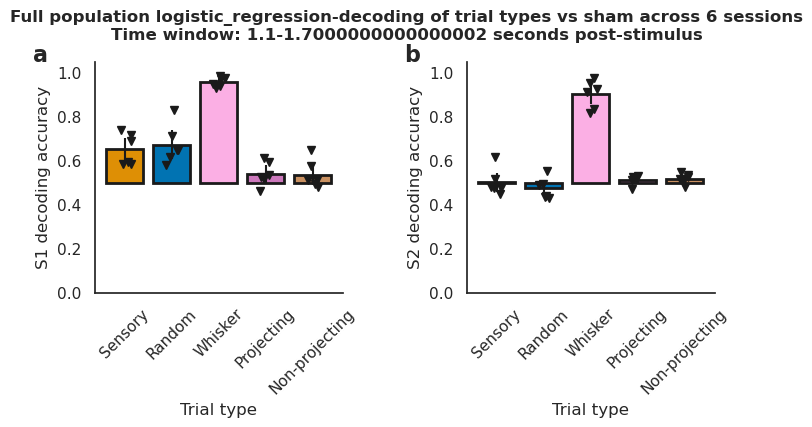

In [16]:
## Load results
# folder_save = '/home/tplas/repos/S1S2_mechanisms/jupyter/thijs/results_decoders/'
# decoder_type = 'logistic_regression'
# exclude_targets = True
# t_min = 1.1 
# t_max = t_min + 0.6
# file_name = f'population-decoder_{decoder_type}_exclude_targets_{exclude_targets}_tmin_{t_min}_tmax_{t_max}.pkl'
# with open(os.path.join(folder_save, file_name), 'rb') as f:
#     scores_dict = pickle.load(f)
# print(f'Loaded results from {os.path.join(folder_save, file_name)}')

ax = dav.bar_plot_decoder_accuracy(scores_dict=scores_dict, decoder_type=decoder_type, 
                                   add_indiv=True,
                                   t_min=t_min, t_max=t_max, save_fig=False, exclude_targets=exclude_targets)

In [17]:
scores_dict

{'s1': {'sens': {'sensory': array([0.585, 0.595, 0.585, 0.69 , 0.715, 0.74 ]),
   'random': array([0.58 , 0.65 , 0.71 , 0.65 , 0.615, 0.83 ]),
   'whisker': array([0.975, 0.985, 0.93 , 0.95 , 0.97 , 0.94 ])},
  'proj': {'projecting': array([0.525, 0.595, 0.535, 0.46 , 0.61 , 0.515]),
   'non_projecting': array([0.495, 0.51 , 0.65 , 0.48 , 0.575, 0.51 ])}},
 's2': {'sens': {'sensory': array([0.475, 0.48 , 0.45 , 0.475, 0.515, 0.615]),
   'random': array([0.435, 0.555, 0.49 , 0.43 , 0.44 , 0.495]),
   'whisker': array([0.925, 0.955, 0.91 , 0.835, 0.975, 0.815])},
  'proj': {'projecting': array([0.51 , 0.525, 0.52 , 0.53 , 0.515, 0.47 ]),
   'non_projecting': array([0.515, 0.525, 0.48 , 0.535, 0.55 , 0.505])}}}

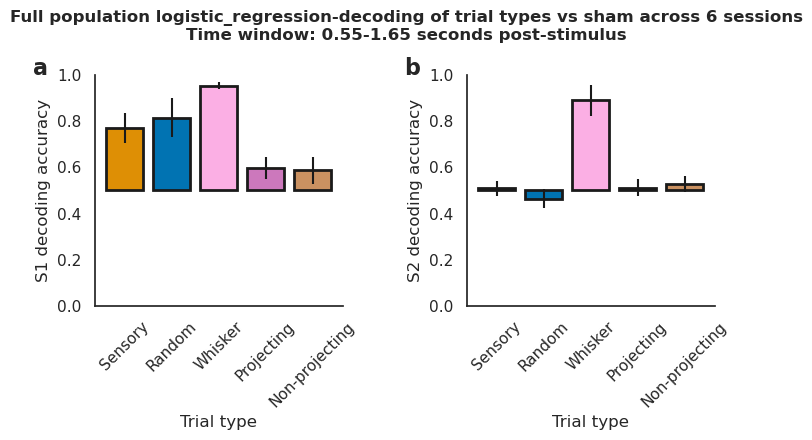

In [6]:
ax = dav.bar_plot_decoder_accuracy(scores_dict=scores_dict, decoder_type=decoder_type, 
                                   t_min=t_min, t_max=t_max, save_fig=False, exclude_targets=exclude_targets)

In [32]:
scores_dict

{'s1': {'sens': {'sensory': array([0.645, 0.83 , 0.715, 0.73 , 0.815, 0.88 ]),
   'random': array([0.725, 0.89 , 0.81 , 0.68 , 0.785, 0.995]),
   'whisker': array([0.975, 0.965, 0.915, 0.945, 0.97 , 0.945])},
  'proj': {'projecting': array([0.555, 0.57 , 0.69 , 0.505, 0.61 , 0.64 ]),
   'non_projecting': array([0.605, 0.525, 0.71 , 0.515, 0.52 , 0.64 ])}},
 's2': {'sens': {'sensory': array([0.43 , 0.505, 0.55 , 0.5  , 0.515, 0.545]),
   'random': array([0.46 , 0.495, 0.515, 0.355, 0.465, 0.485]),
   'whisker': array([0.955, 0.93 , 0.93 , 0.81 , 0.97 , 0.74 ])},
  'proj': {'projecting': array([0.56 , 0.555, 0.47 , 0.535, 0.44 , 0.505]),
   'non_projecting': array([0.545, 0.5  , 0.49 , 0.615, 0.49 , 0.52 ])}}}

In [33]:
data_acc = {
    'accuracy': [], 'session_id': [], 'group_id': [], 'trial_type': [], 'region': []
}
for region, sess_dict in scores_dict.items():
    for sess_type, tt_dict in sess_dict.items():
        for tt, acc_arr in tt_dict.items():
            if tt == 'whisker':
                print('skippin whisker')
                continue
            data_acc['accuracy'].extend(acc_arr)
            data_acc['session_id'].extend(range(n_sessions))
            data_acc['group_id'].extend([f'{sess_type} {region}']*n_sessions)
            data_acc['trial_type'].extend([tt]*n_sessions)
            data_acc['region'].extend([region]*n_sessions)

# data_acc
df_acc = pd.DataFrame(data_acc)

## anova 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula = 'accuracy ~ C(group_id) + C(trial_type) + C(region)'#+ C(group_id):C(trial_type)'
model = ols(formula, df_acc).fit()
aov_table = anova_lm(model, typ=2)
aov_table

skippin whisker
skippin whisker


,sum_sq,df,F,PR(>F)
C(group_id),0.648985,3.0,41.643692,1.192619e-12
C(trial_type),0.086402,3.0,5.544179,2.679395e-03
C(region),0.122261,1.0,23.535441,1.722554e-05
Residual,0.218179,42.0,NaN,NaN


## Show average population activity:

Neurons sorted by sum
Neurons sorted by sum
Neurons sorted by sum
Neurons sorted by sum
Neurons sorted by sum
Neurons sorted by sum


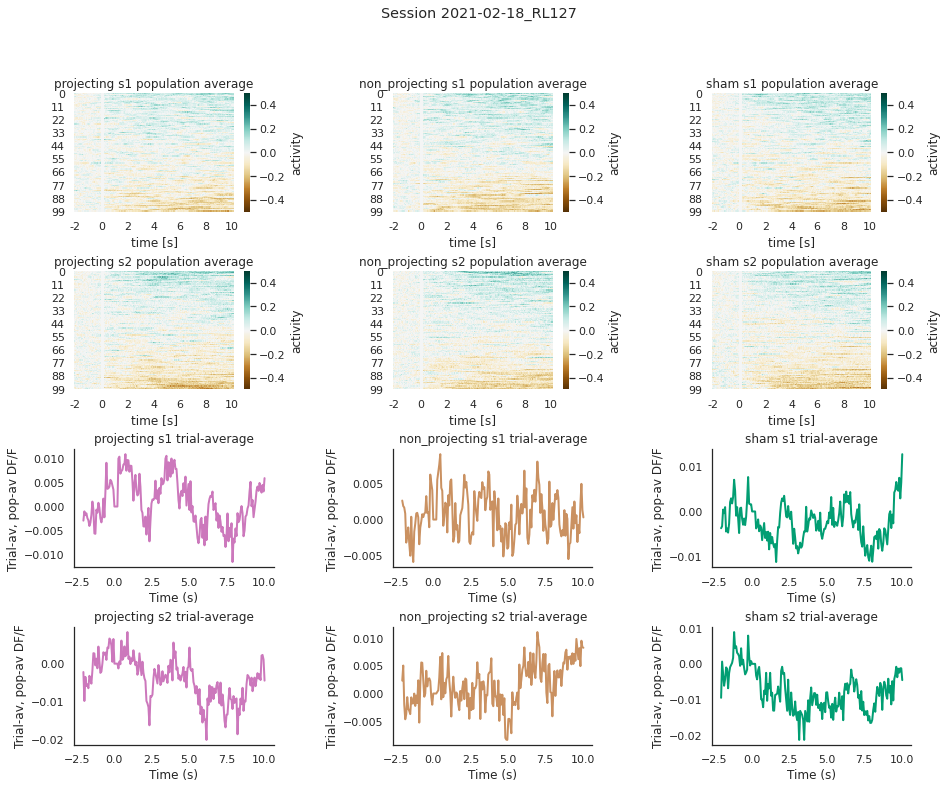

In [14]:
tmps = dav.plot_pop_av(Ses=all_sess['proj'].sess_dict[0],  #tmp, 
                       region_list=['s1', 's2'], sort_trials_per_tt=True,
                        plot_trial_av=True)

# Find responding cells
Using method (and adapted code) from Rowland et al.:

*Neurons were categorised as responsive or unresponsive to stimulus or reward in a trial-wise manner. For each trial, the distribution of ΔF/F values 500 ms pre-stimulus were compared to 500 ms post-stimulus for each cell. A cell was deemed as responsive to a stimulus on an individual trial if it passed a significance threshold of p = 0.05, using a two-sided Wilcoxon signed-rank test, following false discovery rate (FDR) correction. The alpha of the FDR correction (0.015) was set empirically as the value which yielded ∼5% of cells responding on correct rejection trials, where there was no stimulation or licking response. Following significance testing, cells were split into positively and negatively responding cells based on whether the mean ΔF/F value post-stimulus was greater or less than the mean ΔF/F value pre-stimulus respectively. While calcium imaging with GCaMP does not visualise inhibition explicitly, it has been shown that deviations of fluorescence traces below baseline is indicative of inhibition of tonically active neurons79. The fraction of neurons excited or inhibited on a given trial, in a given brain region, was defined as the number of positively or negatively responding cells respectively, divided by the total number of neurons recorded in that brain region on that session.*

**The code to compute responders is now in `compute_responders.py`**

In [6]:
stat_test_use = 'wilcoxon'
fdr_rate_use = '5e-01'

## Load
with open(f'results_responders/df_responders_s1_{stat_test_use}_window-16-timepoints_fdr-{fdr_rate_use}.pkl', 'rb') as f:
    dict_df_responders_s1 = pickle.load(f)

with open(f'results_responders/df_responders_s2_{stat_test_use}_window-16-timepoints_fdr-{fdr_rate_use}.pkl', 'rb') as f:
    dict_df_responders_s2 = pickle.load(f)

dict_df_responders_use = dict_df_responders_s2

In [128]:
dict_df_responders_use['sens'][0]

,percent_positive_responders,percent_negative_responders,n_positive_responders,n_negative_responders,trial_type,trial,session_name_readable
0,13.049096,25.968992,101.0,201.0,sensory,0,2020-09-04_RL093
1,13.178295,27.777778,102.0,215.0,sensory,1,2020-09-04_RL093
2,20.413437,18.217054,158.0,141.0,sensory,2,2020-09-04_RL093
3,29.198966,18.346253,226.0,142.0,sensory,3,2020-09-04_RL093
4,12.015504,20.025840,93.0,155.0,sensory,4,2020-09-04_RL093
...,...,...,...,...,...,...,...
395,18.992248,28.294574,147.0,219.0,whisker,395,2020-09-04_RL093
396,43.023256,8.914729,333.0,69.0,whisker,396,2020-09-04_RL093
397,37.596899,13.178295,291.0,102.0,whisker,397,2020-09-04_RL093
398,15.762274,32.428941,122.0,251.0,whisker,398,2020-09-04_RL093


In [10]:
sess_type = 'sens'
sess_id = 0

trial_slice = slice(300, 400)
curr_df = dict_df_responders_use[sess_type][sess_id][trial_slice]
curr_ds = all_sess[sess_type].sess_dict[sess_id].full_ds
# plt.scatter(curr_df['percent_positive_responders'], curr_df['percent_negative_responders'], s=10)
# np.corrcoef(curr_df['percent_positive_responders'], curr_df['percent_negative_responders'])
total_responders = curr_df['percent_positive_responders'] + curr_df['percent_negative_responders']
inds_sorted = np.argsort(total_responders)
metric_plot = curr_ds.sel(time=slice(-0.6, -0.1)).mean('time').var('neuron').activity[trial_slice]
# metric_plot = np.log(metric_plot)
## z-score2
# metric_plot = (metric_plot - metric_plot.mean()) / metric_plot.std()
plt.scatter(metric_plot, total_responders, s=10)
plt.xlabel('Population variance')
plt.ylabel('Total responders')
print(np.corrcoef(metric_plot, total_responders)[1, 0])
print(scipy.stats.pearsonr(metric_plot, total_responders))

NameError: name 'dict_df_responders_use' is not defined

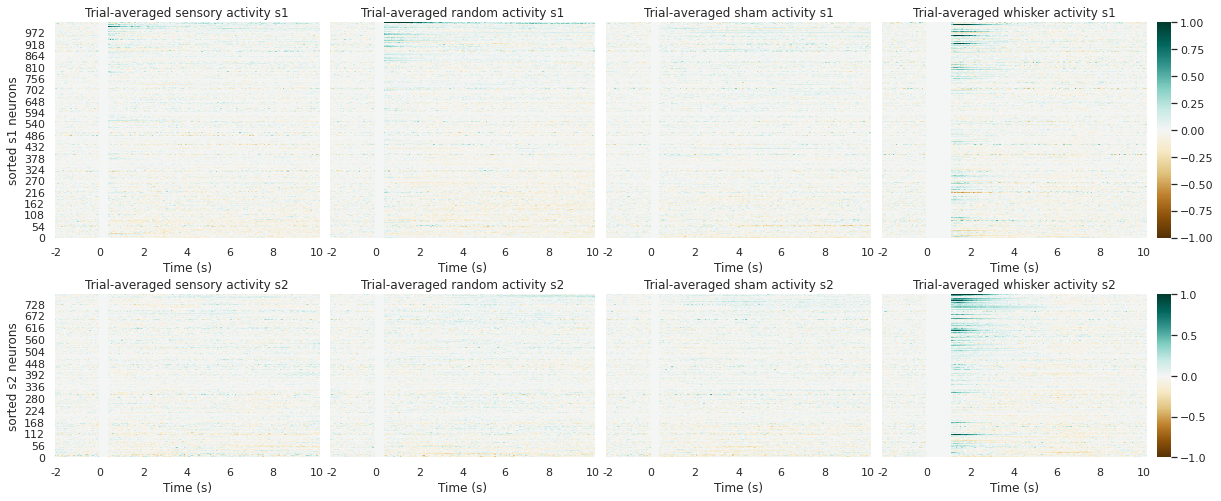

In [13]:
sess_type = 'sens'
sess_id = 0
full_ds = all_sess[sess_type].sess_dict[sess_id].full_ds
n_trialtypes = len(np.unique(full_ds.trial_type)) 
fraction_s1_neuron = np.sum(full_ds.cell_s1) / len(full_ds.cell_s1)
save_path = '/home/tplas/repos/S1S2_mechanisms/jupyter/thijs/figs/figs_trial-average_activity_per_session/'
save_fig = False
rasterize_heatmaps = True

fig, ax = plt.subplots(2, n_trialtypes + 1, figsize=(5 * n_trialtypes, 8), gridspec_kw={'wspace': 0.05, 'hspace': 0.3 ,'width_ratios': [1] * n_trialtypes + [0.05],
                                                           'height_ratios': [fraction_s1_neuron, 1 - fraction_s1_neuron]})
# inds_sorted_neurons = np.argsort(full_ds.activity.mean(['trial', 'time']).data)
inds_sorted_neurons_dict = {'s1': np.argsort(full_ds.activity.mean(['trial', 'time']).sel(neuron=full_ds.cell_s1).data),
                            's2': np.argsort(full_ds.activity.mean(['trial', 'time']).sel(neuron=np.logical_not(full_ds.cell_s1)).data)}

for i_trial in range(n_trialtypes):
    start_trial = i_trial * 100 
    end_trial = (i_trial + 1) * 100 - 1
    trial_slice = slice(start_trial, end_trial)
    # curr_df = dict_df_responders_use[sess_type][sess_id][trial_slice]
    curr_ds = full_ds.sel(trial=trial_slice)
    assert len(np.unique(curr_ds.trial_type)) == 1, f'There are multiple trial types in this slice: {curr_ds.trial_type}'
    assert curr_ds.dims['trial'] == 100
    current_trialtype = curr_ds.trial_type[0].data

    for ir, region in enumerate(['s1', 's2']):
        # plot_data = curr_ds.activity.sel(trial=86 + i_trial * 100).sel(neuron=curr_ds.cell_s1 if region == 's1' else np.logical_not(curr_ds.cell_s1)).data 
        plot_data = curr_ds.activity.mean('trial').sel(neuron=curr_ds.cell_s1 if region == 's1' else np.logical_not(curr_ds.cell_s1)).data 
        plot_data = plot_data[inds_sorted_neurons_dict[region]]

        sns.heatmap(plot_data, cmap='BrBG', vmin=-1, vmax=1, ax=ax[ir, i_trial], 
                    cbar=True if i_trial == n_trialtypes - 1 else False, cbar_ax=ax[ir, -1],
                    rasterized=rasterize_heatmaps)
        if i_trial == 0:
            ax[ir, i_trial].set_ylabel(f'sorted {region} neurons')
        else:
            ax[ir, i_trial].set_ylabel('')
            ## remove yticklabels 
            ax[ir, i_trial].set_yticklabels([])
        ax[ir, i_trial].set_xlabel('Time (s)')
        dav.create_time_axis(ax=ax[ir, i_trial], time_arr=curr_ds.time.data, label_list=[-2, 0, 2, 4, 6, 8, 10])
        ax[ir, i_trial].set_title(f'Trial-averaged {current_trialtype} activity {region}')
        ax[ir, i_trial].invert_yaxis()

if save_fig:
    plt.savefig(save_path + f'trial-averaged_activity_session-{sess_type}-{sess_id}.pdf', bbox_to_anchor='tight')

In [129]:
inds_blanked_out = np.where(curr_ds.activity.mean(['neuron', 'trial']) == 0)[0]
curr_ds.time[inds_blanked_out]

<xarray.DataArray 'time' (time: 17)>
array([0.0114  , 0.078332, 0.145263, 0.212195, 0.279126, 0.346058, 0.412989,
       0.47992 , 0.546852, 0.613783, 0.680715, 0.747646, 0.814578, 0.881509,
       0.948441, 1.015372, 1.082303])
Coordinates:
  * time     (time) float64 0.0114 0.07833 0.1453 0.2122 ... 0.9484 1.015 1.082
Attributes:
    units:    s

In [15]:
dict_df_responders_s2[sess_type][sess_id].groupby(['trial_type', 'session_name_readable']).mean()

,,percent_positive_responders,percent_negative_responders,n_positive_responders,n_negative_responders,trial
trial_type,session_name_readable,,,,,
random,2020-09-04_RL093,2.158915,1.855297,16.71,14.36,149.5
sensory,2020-09-04_RL093,2.382429,2.121447,18.44,16.42,49.5
sham,2020-09-04_RL093,2.122739,1.820413,16.43,14.09,249.5
whisker,2020-09-04_RL093,6.303618,1.697674,48.79,13.14,349.5


In [9]:
# plot_data = curr_ds.activity.sel(trial=inds_sorted.to_numpy()[4]).data
plot_data = curr_ds.activity.mean('trial').data
inds_sorted_neurons = np.argsort(plot_data.mean(1))
plot_data = plot_data[inds_sorted_neurons]

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
sns.heatmap(plot_data, cmap='BrBG', vmin=-1, vmax=1, ax=ax)
ax.set_ylabel('sorted neurons')
ax.set_xlabel('Time (s)')
dav.create_time_axis(ax=ax, time_arr=curr_ds.time.data, label_list=[-2, 0, 2, 4, 6, 8, 10])
ax.set_title('Population activity of most excited sensory trial')
ax.invert_yaxis()

NameError: name 'curr_ds' is not defined

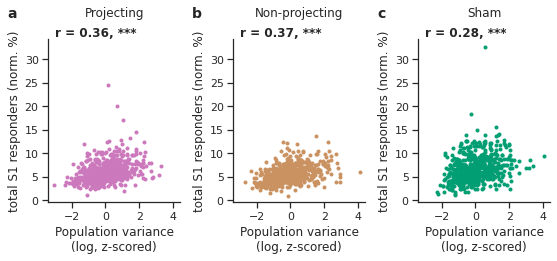

In [252]:
st = 'proj'
df_s1_comb, df_s2_comb = dav.load_responders_different()
dict_df_responders_use = df_s2_comb
dav.overview_plot_metric_vs_responders(sess_dict=all_sess[st].sess_dict, sess_type=st,
                                       dict_df_responders_s1=df_s1_comb, dict_df_responders_s2=df_s2_comb,
                                       region_use='s1',
                                       metric ='pop_var', zscore_metric=True, 
                                       response_type='total', 
                                       plot_individual_sessions=False,
                                       save_fig=True)

Text(0.5, 1.0, 'S2 responding cells')

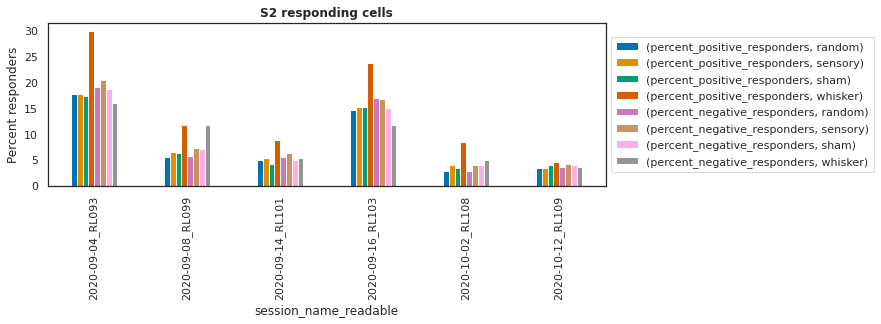

In [7]:
dict_df_responders_use = dict_df_responders_s2
df_concat = pd.concat(list(dict_df_responders_use['sens'].values()))
# df_concat = tmp
df_tmp_result = df_concat.groupby(['session_name_readable', 'trial_type',]).mean()
for col_tmp in ['n_positive_responders_targets', 'n_negative_responders_targets', 'n_positive_responders', 'n_negative_responders', 'trial', ]:
    if col_tmp in df_tmp_result.columns:
        df_tmp_result = df_tmp_result.drop(col_tmp, axis=1)
for col in ['percent_positive_responders', 'percent_negative_responders']:
    df_tmp_result[col] = df_tmp_result[col].apply(lambda x: round(x, 1))

# sns.barplot(df_tmp_result)
sns.set_palette('colorblind')
fig, ax  = plt.subplots(1,1, figsize=(10, 3))
df_tmp_result.unstack().plot(kind='bar', legend=True, ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Percent responders')
plt.title('S2 responding cells', weight='bold')

(0.00784313725490196, 0.6196078431372549, 0.45098039215686275)
Mean values sham_sens: fdr
0.01     1.229880
0.02     1.770376
0.05     2.820550
0.10     4.172219
0.30     9.548639
0.50    17.442614
Name: percent_total_responders, dtype: float64

--

Std values sham_sens: fdr
0.01     1.587749
0.02     2.111209
0.05     3.174056
0.10     4.558366
0.30     8.736655
0.50    12.485936
Name: percent_total_responders, dtype: float64


Mean values sham_proj: fdr
0.01     3.228316
0.02     4.286862
0.05     6.285531
0.10     8.716956
0.30    17.907385
0.50    29.529749
Name: percent_total_responders, dtype: float64

--

Std values sham_proj: fdr
0.01    1.693759
0.02    2.098096
0.05    2.710809
0.10    3.422867
0.30    5.427240
0.50    6.502592
Name: percent_total_responders, dtype: float64




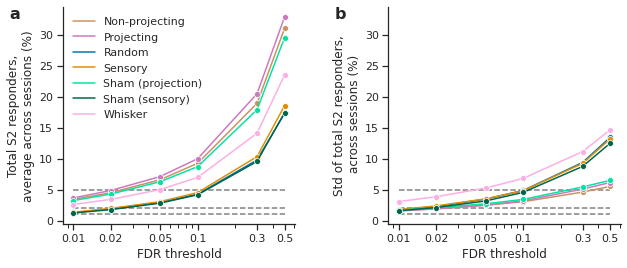

In [22]:
tmp = dav.plot_effect_fdr_responders(save_fig=True, print_sham_stats=True)

In [139]:
tmp[tmp['trial_type'] == 'Sham'].groupby('fdr').mean()

,percent_positive_responders,percent_negative_responders,percent_total_responders
fdr,,,
0.01,1.136952,1.092146,2.229098
0.02,1.525863,1.502756,3.028619
0.05,2.263226,2.289814,4.553041
0.10,3.161876,3.282712,6.444587
0.30,6.625837,7.102175,13.728012
0.50,11.260342,12.225840,23.486181


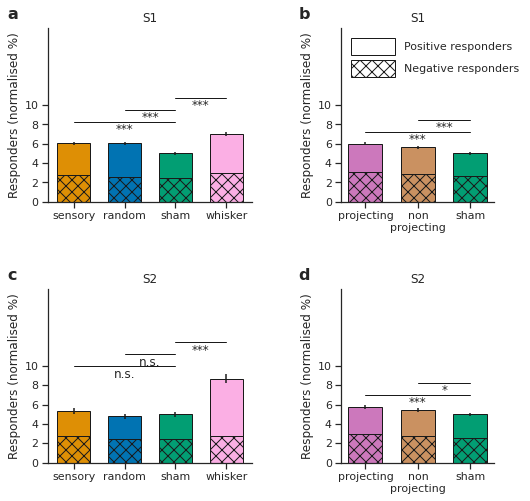

In [258]:
save_fig = False

df_s1_comb, df_s2_comb = dav.load_responders_different(stat_test_use='ttest')
fig, ax = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'wspace': 0.5, 'hspace': 0.5, 'width_ratios': [4, 3]})
for i_st, st in enumerate(['sens', 'proj']):
    for i_ax, dict_df_resp in enumerate([df_s1_comb, df_s2_comb]):
        tmp = dav.plot_average_responders_per_trial_type(dict_df_responders=dict_df_resp, sess_type=st, ax=ax[i_ax, i_st],
                                                        plot_pos_neg_separately=False, n_bonf=10,
                                                        plot_legend=(st =='proj' and i_ax == 0),
                                                        plot_stats=True,
                                                        # add_y=1.5,
                                                        #  list_tt_ignore=['sensory'])
                                                        # list_trial_numbers_ignore=list(np.concatenate([np.arange(10 + x, 100 + x) for x in 100 * np.arange(4)]))
        )
        ax[i_ax, i_st].set_ylim([0, 18])
    ax[0, i_st].set_title(f'S1') # (first 10 trial only)')
    ax[1, i_st].set_title(f'S2') # (first 10 trial only)')

for i_lab, lab in enumerate('abcd'):
    ax.flatten()[i_lab].annotate(lab, (-0.2 - 0.08 * (i_lab % 2), 1.05), xycoords='axes fraction', weight='bold', fontsize=16)

if save_fig:
    plt.savefig('figs/fig_barplots_av_responders_first10trials.pdf', bbox_inches='tight')

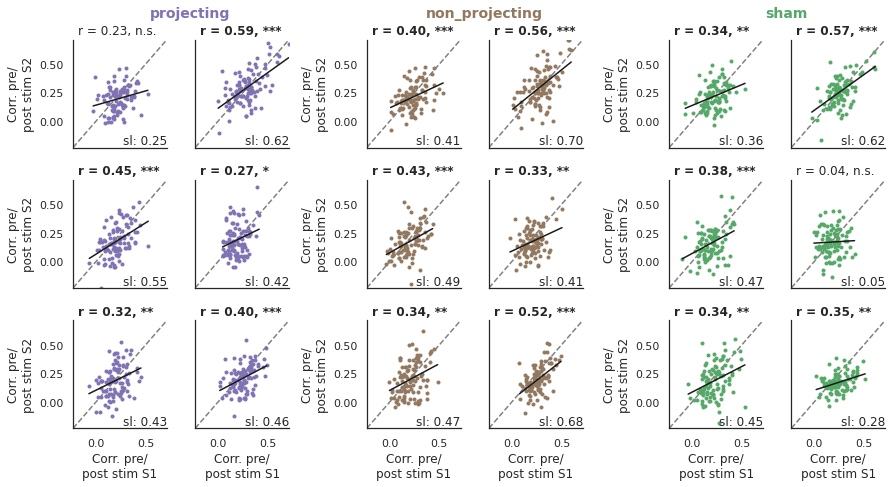

In [117]:
st = 'proj'
tmp = dav.overview_plot_correlations(sess_dict=all_sess[st].sess_dict, sess_type=st, 
                               comparison='pre_vs_post',
                            # comparison='s1_vs_s2',
                               append_to_title='')

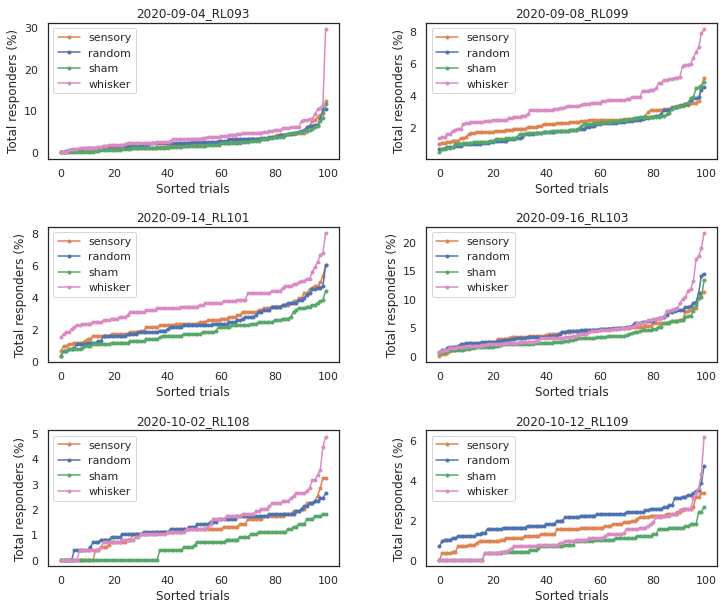

In [32]:
dav.plot_sorted_responders_per_trial_type(dict_df_responders=dict_df_responders_s1['sens'])

sens 0
R-squared (linear): 0.28, R-squared (exponential): 0.33
sens 1
R-squared (linear): 0.23, R-squared (exponential): 0.28
proj 0
R-squared (linear): 0.46, R-squared (exponential): 0.46
proj 1
R-squared (linear): 0.42, R-squared (exponential): 0.57


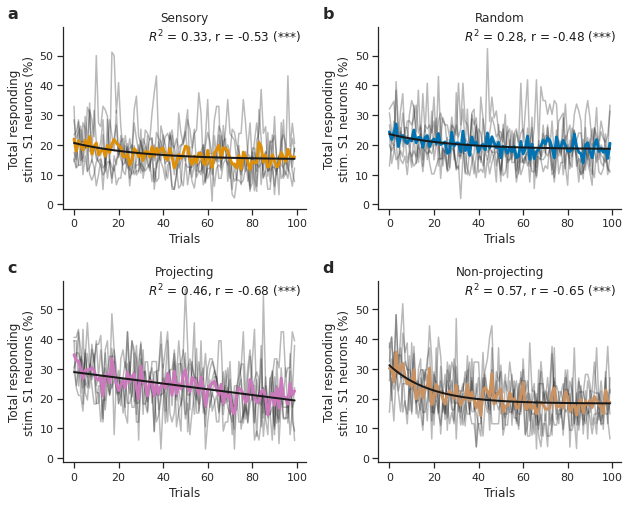

In [227]:
dav.plot_change_target_response(dict_df_responders_s1=df_s1_comb, save_fig=True)


## Similarity spont vs stim

In [25]:
tmp_ds = all_sess['proj'].sess_dict[0].full_ds
# tmp_ds = tmp_ds.sel(neuron=tmp_ds.cell_s1).sel(trial=slice(0, 100))
# stim_vector = tmp_ds.targets_sensory.values.astype(int)
# print(f'Number of targeted neurons: {np.sum(stim_vector)}')

# activity_vector_per_trial = tmp_ds.activity.sel(time=slice(-0.6, -0.1)).mean('time')
# similarity_array = np.dot(stim_vector, activity_vector_per_trial.values)
# similarity_array

(array([ 3., 14., 39., 50., 64., 62., 32., 21., 12.,  3.]),
 array([-0.08061209, -0.01968514,  0.04124181,  0.10216876,  0.16309571,
         0.22402266,  0.28494961,  0.34587656,  0.40680351,  0.46773046,
         0.52865742]),
 <BarContainer object of 10 artists>)

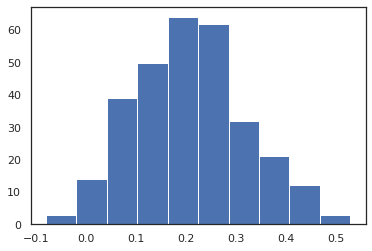

In [26]:
tmp_ds_pre = tmp_ds.sel(time=slice(-0.6, -0.1)).sel(neuron=np.logical_not(tmp_ds.cell_s1)).mean('time')
tmp_ds_post = tmp_ds.sel(time=slice(0.6, 1.1)).sel(neuron=np.logical_not(tmp_ds.cell_s1)).mean('time')

n_trials = 300
cc_trials = np.zeros(n_trials)
for i_trial in range(n_trials):
    cc = np.corrcoef(tmp_ds_pre.sel(trial=i_trial).activity.values, tmp_ds_post.sel(trial=i_trial).activity.values)
    cc = cc[0, 1]
    cc_trials[i_trial] = cc

plt.hist(cc_trials)

# tmp_cc = np.corrcoef(tmp_ds_pre.activity.values.T, tmp_ds_post.activity.values.T)
# print(tmp_ds_pre.activity.shape)
# # tmp_cc.shape

# fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# sns.heatmap(tmp_cc, cmap='RdBu_r', center=0, vmin=-1, vmax=1, 
#             ax=ax, xticklabels=False, yticklabels=False)

In [ ]:
n_pos_resp, n_neg_resp, tmp_ds, df_results = dav.get_percent_cells_responding(session=all_sess['sens'].sess_dict[0], 
                                                                               fdr_rate=0.1,
                                                                               get_responders_targets=True,
                                                                                region='s1')

In [91]:
df_results


,percent_positive_responders,percent_negative_responders,n_positive_responders,n_negative_responders,trial_type,trial,session_name_readable,n_positive_responders_targets,n_negative_responders_targets
0,4.015671,5.680705,41.0,58.0,sensory,0,2020-09-04_RL093,9.890110,4.395604
1,3.917728,9.500490,40.0,97.0,sensory,1,2020-09-04_RL093,10.989011,9.890110
2,4.113614,2.448580,42.0,25.0,sensory,2,2020-09-04_RL093,10.989011,2.197802
3,6.856024,4.701273,70.0,48.0,sensory,3,2020-09-04_RL093,9.890110,3.296703
4,10.871694,4.701273,111.0,48.0,sensory,4,2020-09-04_RL093,26.373626,1.098901
...,...,...,...,...,...,...,...,...,...
395,0.000000,0.000000,0.0,0.0,whisker,395,2020-09-04_RL093,NaN,NaN
396,1.958864,0.195886,20.0,2.0,whisker,396,2020-09-04_RL093,NaN,NaN
397,0.000000,0.195886,0.0,2.0,whisker,397,2020-09-04_RL093,NaN,NaN
398,0.000000,0.293830,0.0,3.0,whisker,398,2020-09-04_RL093,NaN,NaN


# Mixed Effects Model


In [3]:
all_sess = {}
perc_kept = []
threshold_max_dff_filtering = 18
for st in ['sens', 'proj']:
    all_sess[st] = dav.AllSessions(sess_type=st, 
                                   threshold_max_dff_filtering=threshold_max_dff_filtering)
    for k, v in all_sess[st].sess_dict.items():
        perc_kept.append(v.n_neurons / v._n_neurons_original)

print(f'On average {np.mean(perc_kept):.2f} of neurons were kept after filtering')

session name : 2020-09-14_RL101.pkl
Excluded 162 out of 2169 neurons
session name : 2020-10-02_RL108.pkl
Excluded 309 out of 2563 neurons
session name : 2020-09-16_RL103.pkl
Excluded 130 out of 2106 neurons
session name : 2020-09-08_RL099.pkl
Excluded 76 out of 2095 neurons
session name : 2020-09-04_RL093.pkl
Excluded 54 out of 2097 neurons
session name : 2020-10-12_RL109.pkl
Excluded 209 out of 2515 neurons
Individual sessions loaded
session name : 2021-02-24_RL132.pkl
Excluded 250 out of 2156 neurons
session name : 2021-02-18_RL127.pkl
Excluded 266 out of 2334 neurons
session name : 2021-02-22_RL128.pkl
Excluded 288 out of 2308 neurons
session name : 2021-02-25_RL131.pkl
Excluded 583 out of 2448 neurons
session name : 2021-03-02_RL130.pkl
Excluded 132 out of 2258 neurons
session name : 2021-02-23_RL129.pkl
Excluded 553 out of 2364 neurons
Individual sessions loaded
On average 0.89 of neurons were kept after filtering


In [10]:

result = namedtuple('result', ['region', 'trial_type', 'coef_min', 'coef_max', 'pval'])
results = []

def fit_mem(results=[], sess_type = 'proj', region='s2', 
            t_min=1.1, t_max=1.6, verbose=0):
    ds_tim_av = all_sess[sess_type].create_time_averaged_response(region=region, t_min=t_min, t_max=t_max,
                                                            exclude_targets=True, 
                                                            subtract_pcs=False, use_pcs=False)

    data = {
        'activity': ds_tim_av.activity.data.flatten(),
        'orig_sess': np.repeat(ds_tim_av.original_session_id.data, ds_tim_av.dims['trial']),
        'trial_type': np.tile(ds_tim_av.trial_type.data, ds_tim_av.dims['neuron'])
    }
    n_trials = len(ds_tim_av.trial_type)
    assert np.unique(data['orig_sess'][:n_trials]) == np.array([0])
    assert len(np.unique(data['trial_type'][:n_trials])) == (4 if sess_type == 'sens' else 3)
    if sess_type == 'sens':  # first trial type will be tested against.
        cats = ['sham', 'random', 'sensory', 'whisker']
    elif sess_type == 'proj':
        cats = ['sham', 'non_projecting','projecting']

    df_mem = pd.DataFrame(data)
    df_mem['orig_sess'] = pd.Categorical(df_mem['orig_sess'].astype(int))
    df_mem['trial_type'] = pd.Categorical(df_mem['trial_type'], 
                                        categories=cats, ordered=True)

    # Fit a mixed-effects model
    mixed_lm = smf.mixedlm("activity ~ trial_type", df_mem, groups=df_mem["orig_sess"])
    mixed_lm_fit = mixed_lm.fit()

    if verbose:
        print(mixed_lm_fit.summary())

    tt_list = cats[1:]
    for tt in tt_list:
        coef_min = mixed_lm_fit.conf_int().loc[f'trial_type[T.{tt}]', 0]
        coef_max = mixed_lm_fit.conf_int().loc[f'trial_type[T.{tt}]', 1]
        pval = mixed_lm_fit.pvalues[f'trial_type[T.{tt}]']
        results.append(result(region=region, trial_type=tt, coef_min=coef_min, coef_max=coef_max, pval=pval))

    return results

results = []
for sess_type in ['sens', 'proj']:
    for region in ['s1', 's2']:
        print(f'Fitting mixed-effects model for {sess_type} in {region}')
        results = fit_mem(results=results, sess_type=sess_type, region=region)

results


Fitting mixed-effects model for sens in s1


/home/tplas/anaconda3/envs/s1s2mech/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Fitting mixed-effects model for sens in s2


/home/tplas/anaconda3/envs/s1s2mech/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Fitting mixed-effects model for proj in s1


/home/tplas/anaconda3/envs/s1s2mech/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Fitting mixed-effects model for proj in s2


/home/tplas/anaconda3/envs/s1s2mech/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


[result(region='s1', trial_type='sensory', coef_min=-0.0031585712737904484, coef_max=-0.0002263189650137797, pval=0.023665642557367365),
 result(region='s1', trial_type='whisker', coef_min=0.020747806682265942, coef_max=0.02368005899104261, pval=8.573932859033508e-194),
 result(region='s1', trial_type='sham', coef_min=0.002188983754199287, coef_max=0.0051212360629759555, pval=1.0276583707920604e-06),
 result(region='s2', trial_type='sensory', coef_min=-0.004412541478895221, coef_max=-0.0003313132929571804, pval=0.02271567921345595),
 result(region='s2', trial_type='whisker', coef_min=0.060953439493178954, coef_max=0.06503466767911699, pval=0.0),
 result(region='s2', trial_type='sham', coef_min=0.003110004379665154, coef_max=0.007191232565603194, pval=7.534534674795994e-07),
 result(region='s1', trial_type='projecting', coef_min=-0.004617661759347055, coef_max=-0.001157226697675245, pval=0.0010722374090731742),
 result(region='s1', trial_type='sham', coef_min=0.0026712450757018285, coef

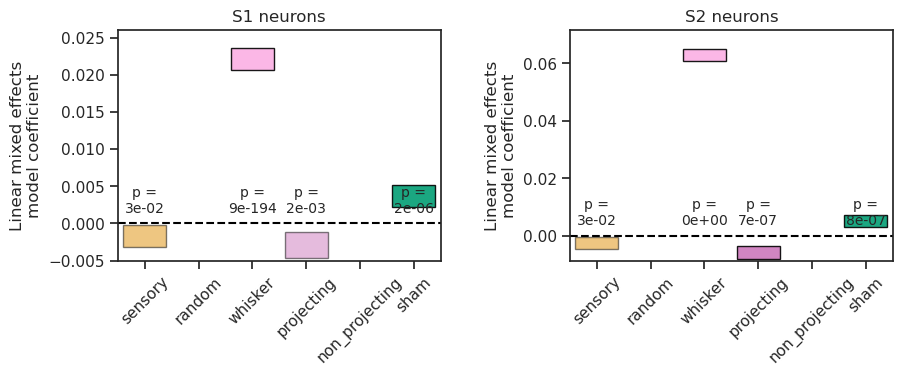

In [11]:
tmp = dav.plot_mem_coefs(results)